# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [7]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
from matplotlib.lines import Line2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [8]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
  make_circles(noise=0.2, factor=0.5, random_state=42),
  make_moons(noise=0.2, random_state=42),
  make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                      n_redundant=0, )
]

In [9]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

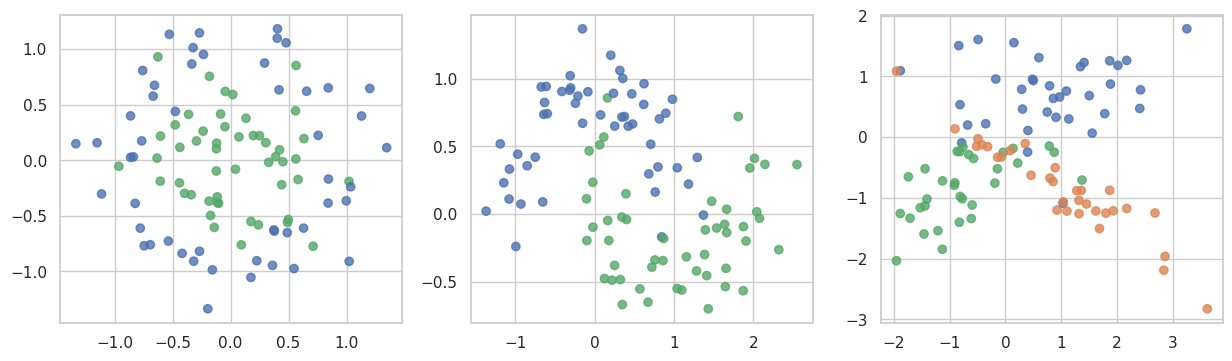

In [10]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
  plt.subplot(1, 3, i + 1)
  plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [11]:
def plot_surface(clf, X, y, title=None, accuracy=None):
  plot_step = 0.01
  palette = sns.color_palette(n_colors=len(np.unique(y)))
  cmap = ListedColormap(palette)
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))
  plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
              edgecolors=np.array(palette)[y], linewidths=2)
  if (title != None):
    plt.title(title)
  if (accuracy != None):
    plt.scatter([], [], alpha=0, label=f'Точность: {accuracy:.3f}')
    plt.legend()

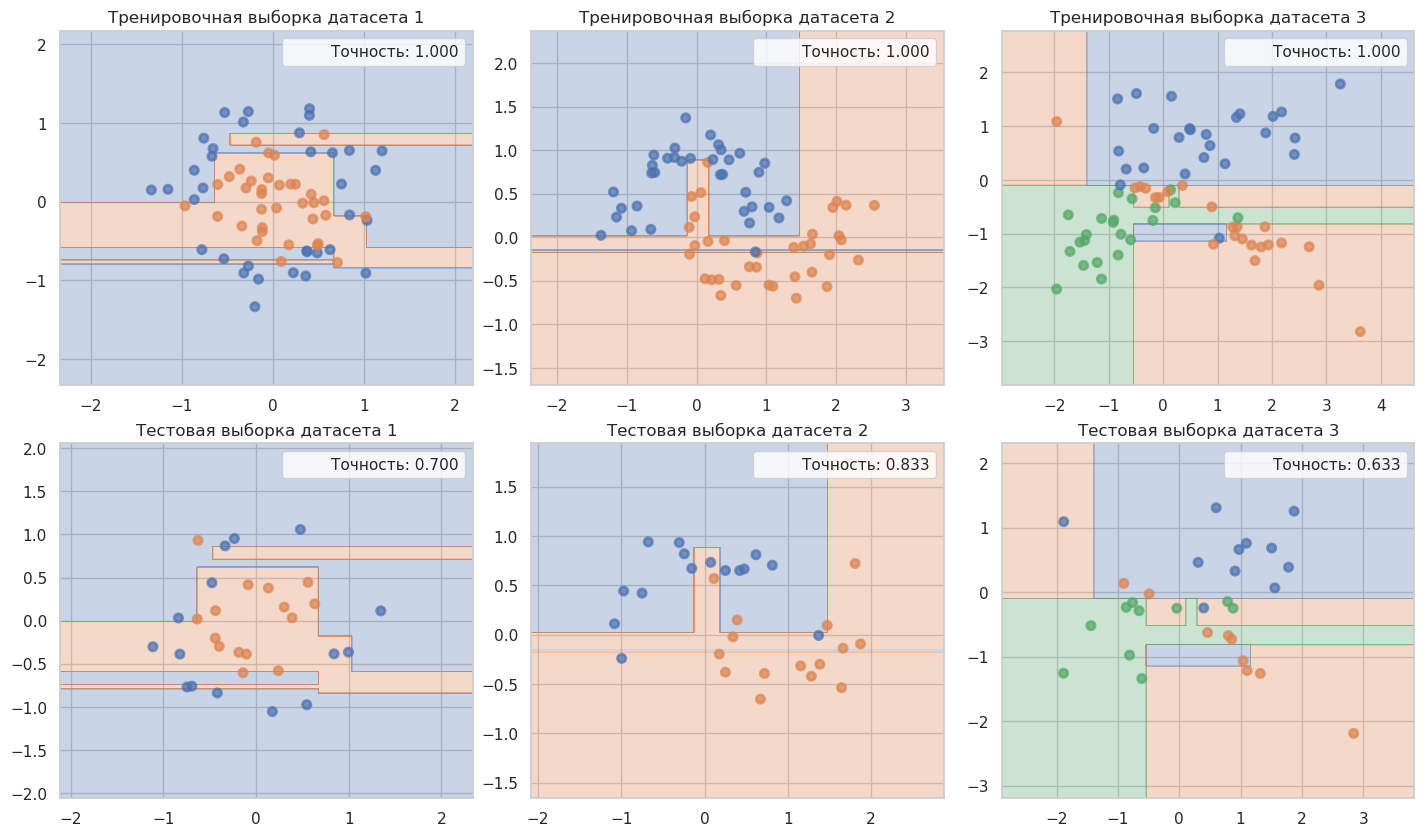

In [12]:
plt.figure(figsize=(15, 9))
for i, (x, y) in enumerate(datasets):
  X, y = datasets[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=444)

  tree = DecisionTreeClassifier(random_state=42)
  tree.fit(X_train, y_train)
  y_pred_train = tree.predict(X_train)
  y_pred_test = tree.predict(X_test)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  plt.subplot(2, 3, i + 1)
  plot_surface(tree, X_train, y_train, f'Тренировочная выборка датасета {i+1}', train_accuracy)
  plt.subplot(2, 3, i + 4)
  plot_surface(tree, X_test, y_test, f'Тестовая выборка датасета {i+1}', test_accuracy)

__Ответ:__ На графиках отчётливо видны тонкие области, соответствующие листам дерева с одним элементом, что свидетельствует о переобучении

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

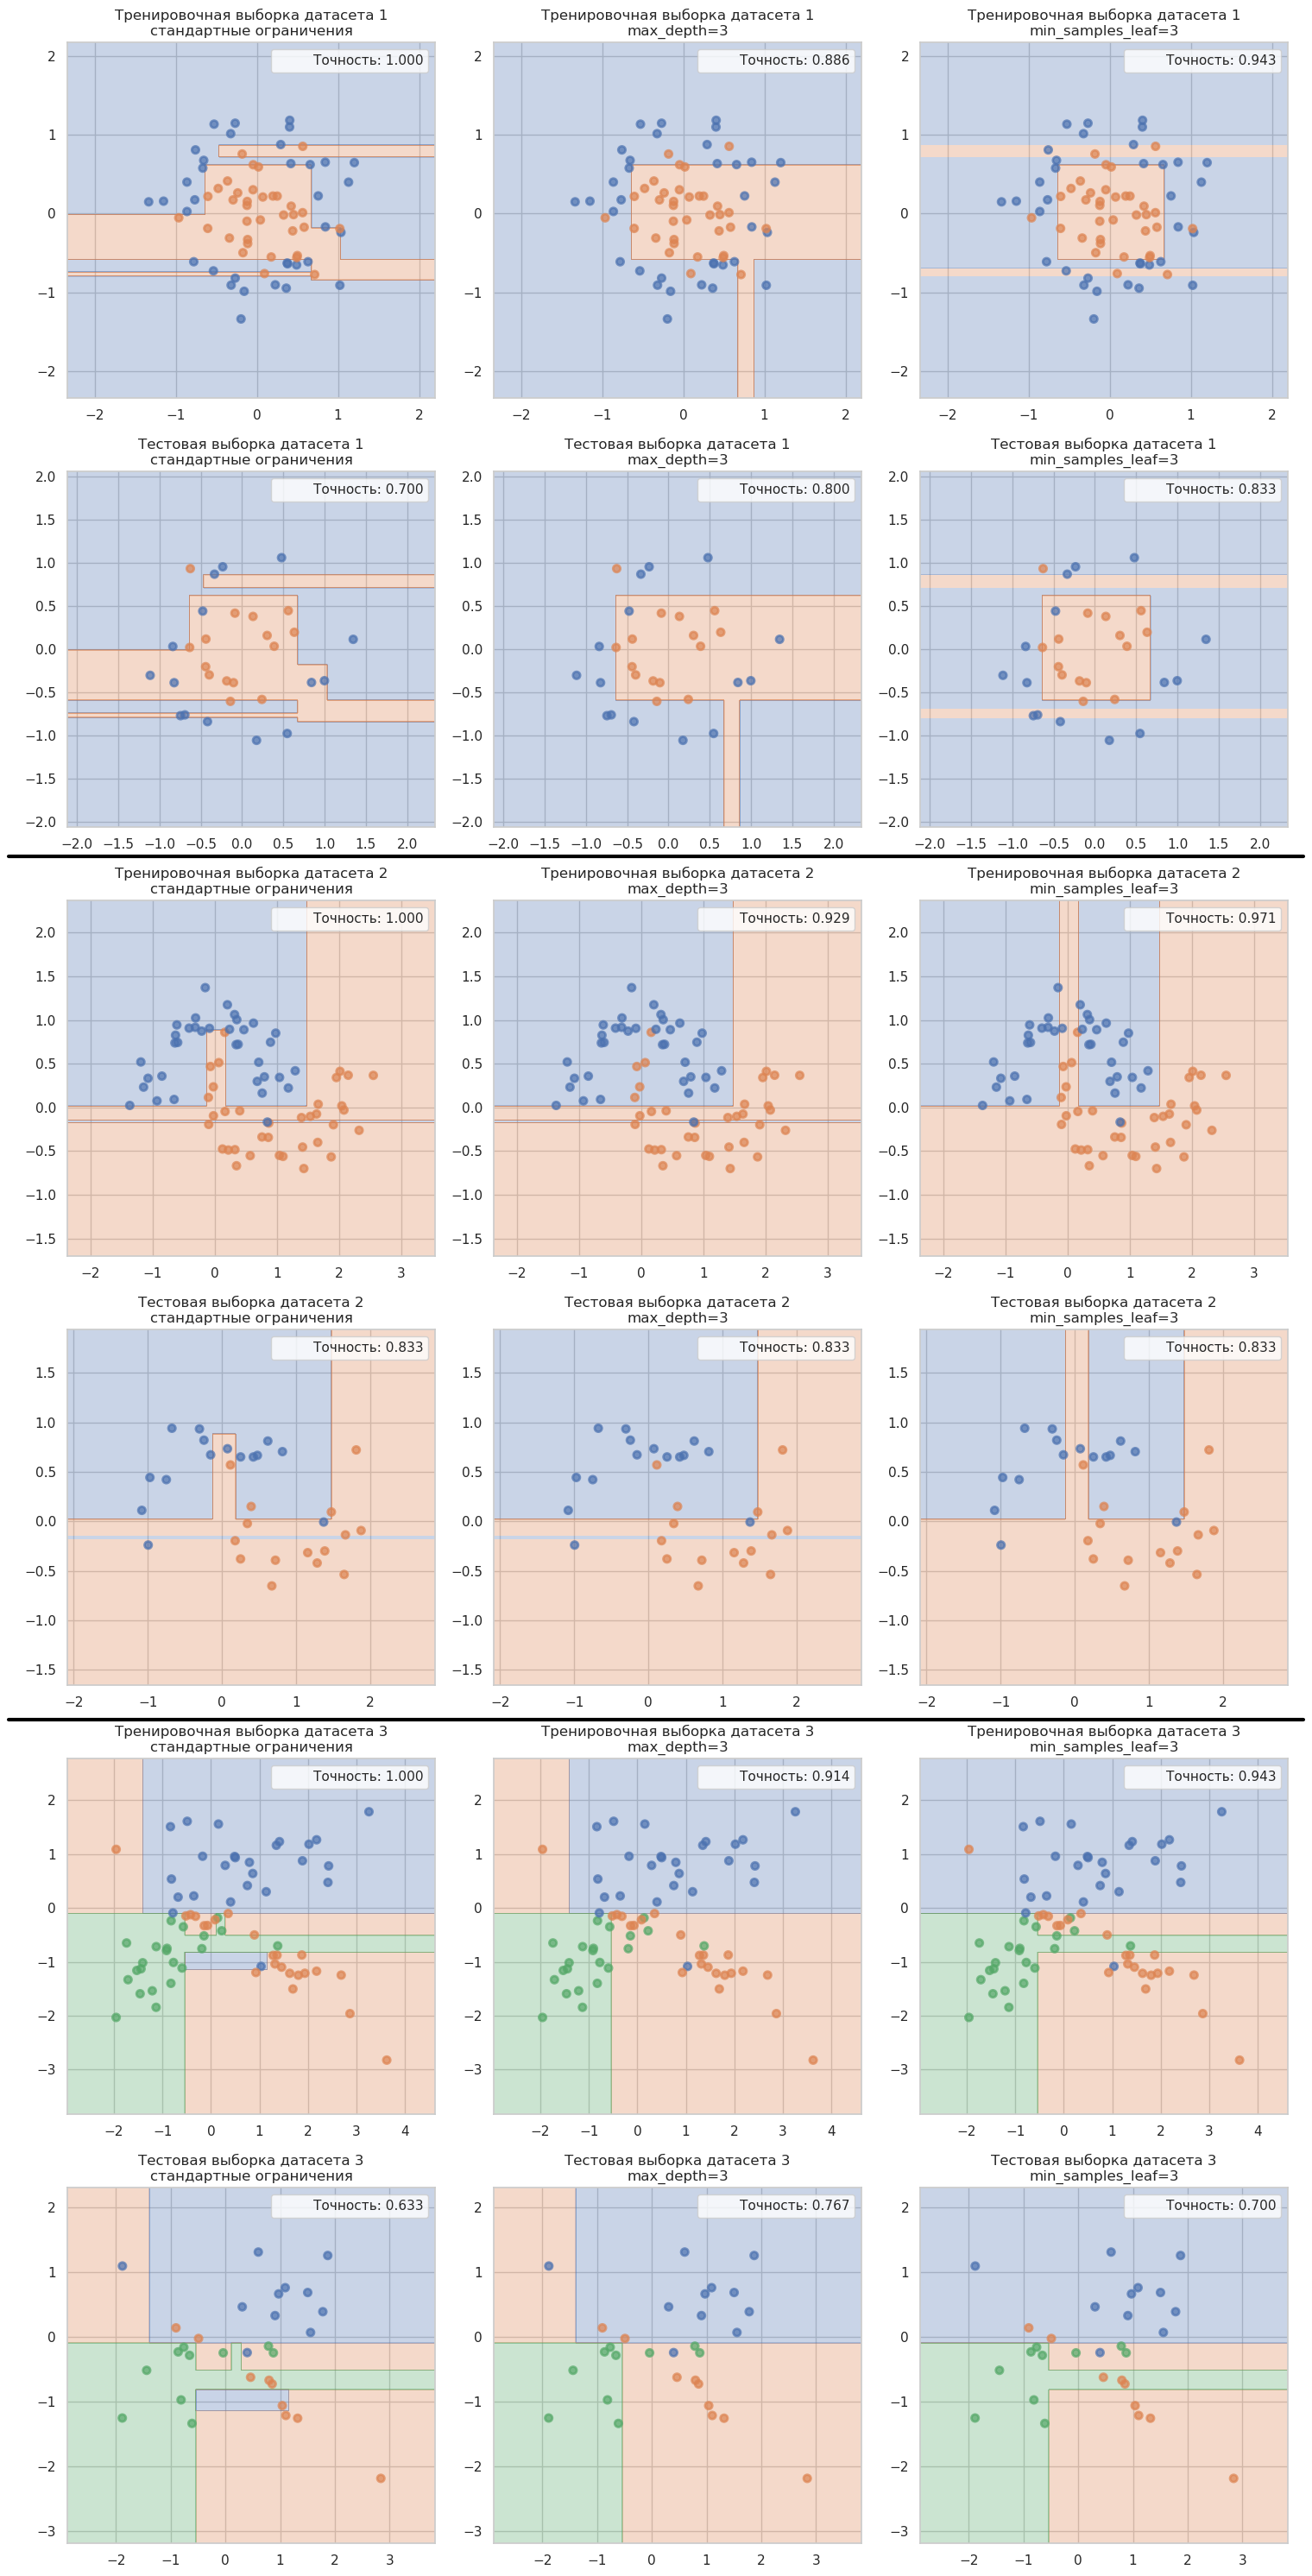

In [13]:
plt.figure(figsize=(15, 30))
for i, (x, y) in enumerate(datasets):
  if (i > 0):
    y = i / len(datasets)
    line = Line2D([0, 1], [y, y], color='black', linewidth=3)
    plt.gcf().figure.add_artist(line)

  X, y = datasets[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=444)

  tree = DecisionTreeClassifier(random_state=42)
  tree.fit(X_train, y_train)
  y_pred_train = tree.predict(X_train)
  y_pred_test = tree.predict(X_test)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  plt.subplot(6, 3, 6*i + 1)
  plot_surface(tree, X_train, y_train, f'Тренировочная выборка датасета {i+1}\nстандартные ограничения', train_accuracy)
  plt.subplot(6, 3, 6*i + 4)
  plot_surface(tree, X_test, y_test, f'Тестовая выборка датасета {i+1}\nстандартные ограничения', test_accuracy)

  tree = DecisionTreeClassifier(max_depth=3, random_state=42)
  tree.fit(X_train, y_train)
  y_pred_train = tree.predict(X_train)
  y_pred_test = tree.predict(X_test)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  plt.subplot(6, 3, 6*i + 2)
  plot_surface(tree, X_train, y_train, f'Тренировочная выборка датасета {i+1}\nmax_depth=3', train_accuracy)
  plt.subplot(6, 3, 6*i + 5)
  plot_surface(tree, X_test, y_test, f'Тестовая выборка датасета {i+1}\nmax_depth=3', test_accuracy)

  tree = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
  tree.fit(X_train, y_train)
  y_pred_train = tree.predict(X_train)
  y_pred_test = tree.predict(X_test)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  plt.subplot(6, 3, 6*i + 3)
  plot_surface(tree, X_train, y_train, f'Тренировочная выборка датасета {i+1}\nmin_samples_leaf=3', train_accuracy)
  plt.subplot(6, 3, 6*i + 6)
  plot_surface(tree, X_test, y_test, f'Тестовая выборка датасета {i+1}\nmin_samples_leaf=3', test_accuracy)

plt.tight_layout()
plt.show()

__Ответ:__ при введении регуляризации количество вершин в дереве уменьшается и обобщающая способность дерева увеличивается. Т.к. рассматриваемые датасеты малы, большее обобщение даёт большую точность. Характер изменений разделяющей поверхности для всех датасетов одинаковый: ограничение глубины дерева приводит к уменьшению количества "прямоугольных кусочков" на графике, а ограничение минимального числа элементов в листе избавляет от узких полос. Точность при этом может не меняться, как во втором датасете, где положительные и отрицательные последствия изменений разделяющей поверхности компенсировали друг друга.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

In [14]:
from hw2code import find_best_split

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [15]:
df = pd.read_csv('data/students.csv')
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


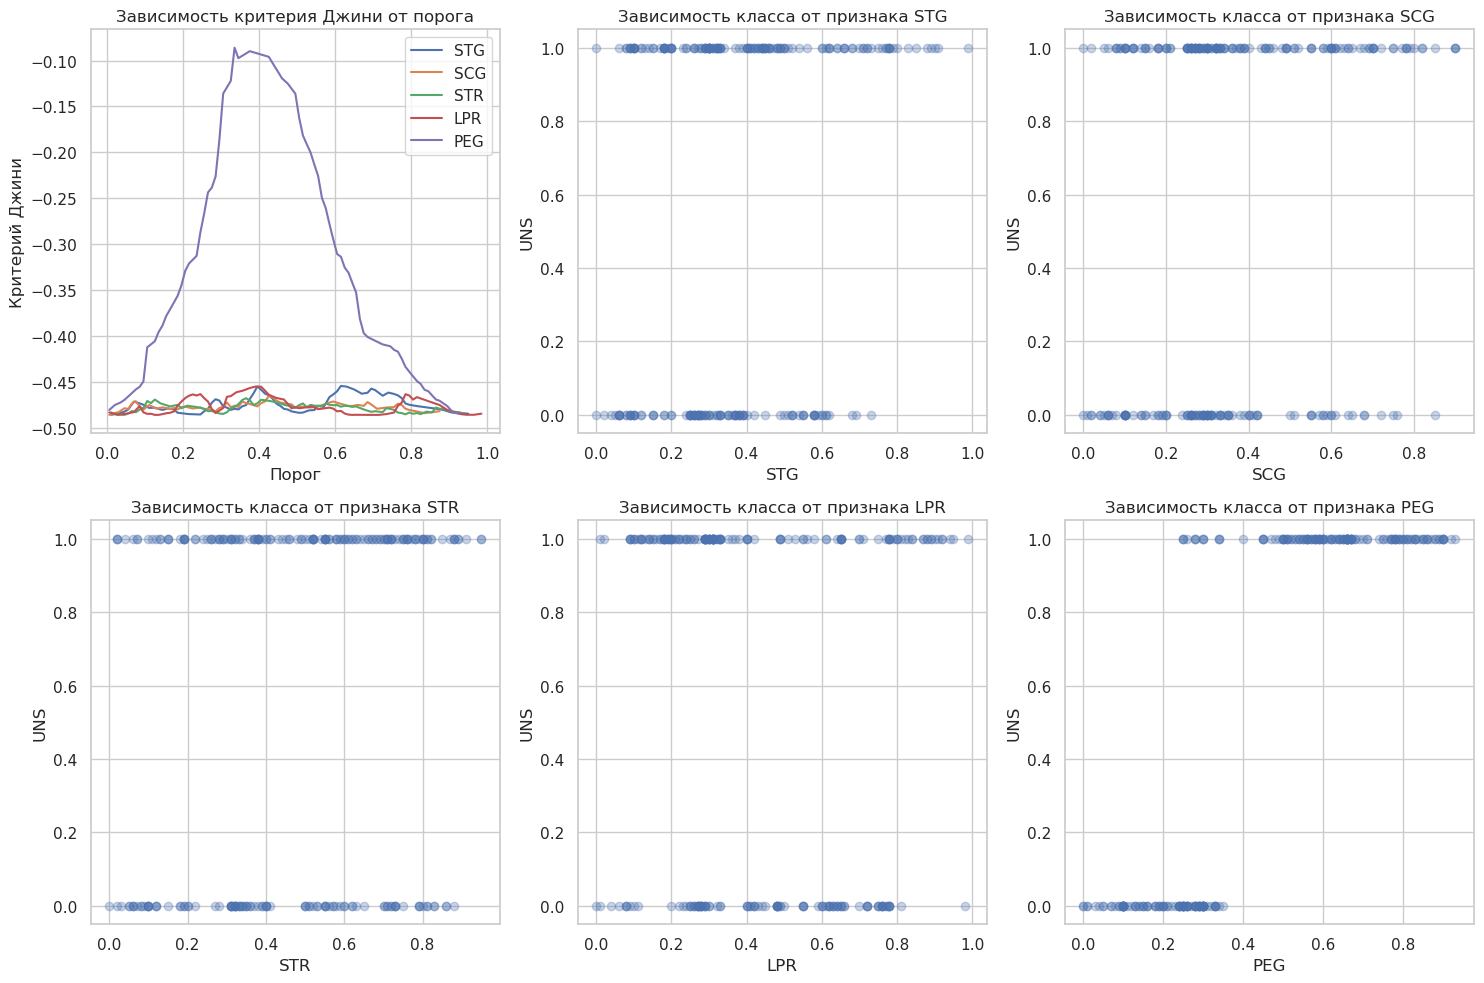

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')

cols = df.drop(columns='UNS').columns

for col in cols:
  thresholds, ginis, _, _ = find_best_split(df[col], df['UNS'])
  plt.plot(thresholds, ginis, label=col)
  plt.title('Зависимость критерия Джини от порога')

plt.legend()

for i in range(0, len(cols)):
  col = cols[i]
  plt.subplot(2, 3, i+2)
  plt.scatter(df[col], df['UNS'], alpha=0.3)
  plt.title(f'Зависимость класса от признака {col}')
  plt.xlabel(col)
  plt.ylabel('UNS')

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Наибольшее значение критерия Джини имеет параметр PEG, значит в первую очередь выборка должна быть поделена именно по нему. Scatter-график PEG отчётливо отличается от остальных: невооружённым глазом видно, что если провести вертикальную линию в PEQ≈0.4, то все точки с классом 0 окажутся слева и большинство точек с классом 1 - справа. Т.е. если выбрать threshold≈0.4, на тренировочной выборке ложно положительных предсказаний не будет вообще, а ложно положительных будет меньше 10%. У других же признаков интервалы значений, относящихся к одному классу куда шире, и так эффективно разделить их невозможно.

Чем меньше у кривой монотонных участков, тем лучше она делит данные. Если их всего два, а максимум кривой находится в центре, то это идеальный случай, когда выборка безошибочно делится на две примерно равные части.

У признаков, по которым деление невозможно, кривая очень сильно колеблется, из-за чего не достигает больших значений критерия Джини.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [17]:
from hw2code import DecisionTree

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [18]:
df = pd.read_csv('data/agaricus-lepiota.data', header=None)

encoder = sk.preprocessing.LabelEncoder()
for col in df.columns:
  df[col] = encoder.fit_transform(df[col])

X = df.drop(columns=0).values
y = df[0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

tree = DecisionTree(['categorical'] * X.shape[1])
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

pd.DataFrame(
    index=['Точность на тренировочной выборке', 'Точность на тренировочной выборке', 'Глубина дерева'],
    data=[train_accuracy, test_accuracy, tree._depth],
    columns=[''])



,
Точность на тренировочной выборке,1.0
Точность на тренировочной выборке,1.0
Глубина дерева,8.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [19]:
mushrooms_df = pd.read_csv('data/agaricus-lepiota.data', header=None)
tic_tac_toe_df = pd.read_csv('data/tic-tac-toe-endgame.csv')
cars_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

In [20]:
mushrooms_target = mushrooms_df.columns[0]
mushrooms_df[mushrooms_target] = mushrooms_df[mushrooms_target].map({'p': 0, 'e': 1})

ttt_target = tic_tac_toe_df.columns[-1]
tic_tac_toe_df[ttt_target] = tic_tac_toe_df[ttt_target].map({'negative': 0, 'positive': 1})

cars_target = cars_df.columns[-1]
cars_df[cars_target] = cars_df[cars_target].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})

nursery_target = nursery_df.columns[-1]
nursery_df[nursery_target] = nursery_df[nursery_target].map(
    {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})

In [21]:
dataframes = [mushrooms_df, tic_tac_toe_df, cars_df, nursery_df]
dataframe_names = ['mushrooms', 'tic_tac_toe', 'cars', 'nursery']
dataframe_targets = [mushrooms_target, ttt_target, cars_target, nursery_target]

In [22]:
encoder = sk.preprocessing.LabelEncoder()
for i in range(len(dataframes)):
  df = dataframes[i]
  for col in df.columns:
    if (col == dataframe_targets[i]):
      continue
    df[col] = encoder.fit_transform(df[col])

In [23]:
class RealDecisionTree:
  def fit(self, X, y):
    self._tree = DecisionTree(['real'] * X.shape[1])
    self._tree.fit(X, y)

  def predict(self, X):
    return self._tree.predict(X)

  def get_params(self, deep=True):
    return {}

class CategoricalDecisionTree:
  def fit(self, X, y):
    self._tree = DecisionTree(['categorical'] * X.shape[1])
    self._tree.fit(X, y)

  def predict(self, X):
    return self._tree.predict(X)

  def get_params(self, deep=True):
    return {}

class OneHotDecisionTree:
  def __init__(self):
    self._encoder = sk.preprocessing.OneHotEncoder(sparse_output=False)

  def fit(self, X, y):
    X = self._encoder.fit_transform(X)
    self._tree = DecisionTree(['real'] * X.shape[1])
    self._tree.fit(X, y)

  def predict(self, X):
    X = self._encoder.transform(X)
    return self._tree.predict(X)

  def get_params(self, deep=True):
    return {}

In [24]:
trees = [RealDecisionTree(), CategoricalDecisionTree(), OneHotDecisionTree(), DecisionTreeClassifier()]
tree_names = ['RealDecisionTree', 'CategoricalDecisionTree', 'OneHotDecisionTree', 'DecisionTreeClassifier']

data = np.ndarray((len(dataframes), len(trees)))

for i in range(len(dataframes)):
  for j in range(len(trees)):
    df = dataframes[i]
    X = df.drop(columns=dataframe_targets[i])
    y = df[dataframe_targets[i]]
    data[i,j] = cross_val_score(trees[j], X, y, cv=10, scoring='accuracy').mean()

name_column = np.array(dataframe_names).reshape(-1, 1)
pd.DataFrame(data=np.column_stack((name_column, data)), columns=['Dataset'] + tree_names)

,Dataset,RealDecisionTree,CategoricalDecisionTree,OneHotDecisionTree,DecisionTreeClassifier
0,mushrooms,0.9992610837438424,1.0,1.0,0.9611225225552747
1,tic_tac_toe,0.6938377192982454,0.7563815789473683,0.5445833333333334,0.7800219298245613
2,cars,0.8656102970829412,0.8656102970829412,0.9258536093560963,0.9427073531388628
3,nursery,0.999537037037037,0.999537037037037,0.9996913580246914,0.9996913580246914


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания: